## Reddit Toxicity Detection

This dataset contains posts from various subreddits, with each entry providing information on the subreddit name, the text content of the post (body), its controversiality (indicating if it sparked significant discussion), and the score (upvotes minus downvotes) received by the post. It can be used to analyze user engagement and sentiment across different subreddits.

### The Dataset has following attributes
1. **subreddit**: The name of the subreddit where the post was made.
2. **body:** The content or text of the post or comment.
3. **controversiality:** Indicates whether the post is controversial (1 for controversial, 0 for not).
4. **score:** The score (upvotes minus downvotes) received by the post.

In [1]:
import pandas as pd
import numpy as np

In [2]:
## read the dataset
df = pd.read_csv("data/kaggle_RC_2019-05.csv")
df.head()

,subreddit,body,controversiality,score
0,gameofthrones,Your submission has been automatically removed...,0,1
1,aww,"Dont squeeze her with you massive hand, you me...",0,19
2,gaming,It's pretty well known and it was a paid produ...,0,3
3,news,You know we have laws against that currently c...,0,10
4,politics,"Yes, there is a difference between gentle supp...",0,1


In [3]:
df.shape

(1000000, 4)

In [4]:
## null values
df.isnull().sum()

subreddit           0
body                0
controversiality    0
score               0
dtype: int64

There are no null values

In [5]:
## Different subreddit categorirs
print(df['subreddit'].unique())
print("\nTotal number of distinct subreddit categories: ",df['subreddit'].nunique())

['gameofthrones' 'aww' 'gaming' 'news' 'politics' 'dankmemes'
 'relationship_advice' 'nba' 'worldnews' 'AskReddit' 'AmItheAsshole'
 'SquaredCircle' 'The_Donald' 'leagueoflegends' 'hockey' 'videos'
 'teenagers' 'gonewild' 'movies' 'funny' 'pics' 'marvelstudios' 'memes'
 'soccer' 'freefolk' 'MortalKombat' 'todayilearned' 'apexlegends' 'asoiaf'
 'Market76' 'Animemes' 'FortNiteBR' 'nfl' 'trashy' 'unpopularopinion'
 'ChapoTrapHouse' 'RoastMe' 'Showerthoughts' 'wallstreetbets' 'Pikabu']

Total number of distinct subreddit categories:  40


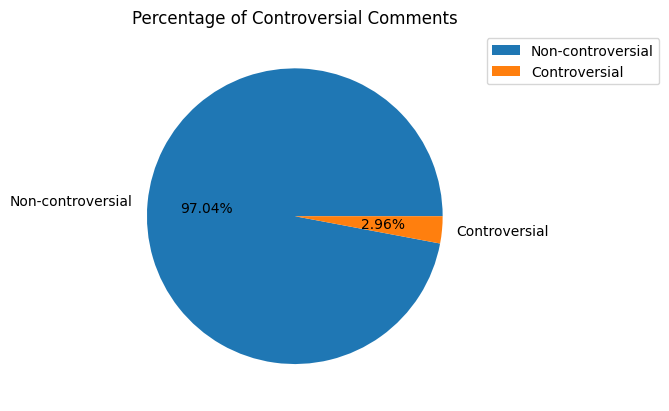

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

size = df['controversiality'].value_counts()

plt.pie(x = size, labels=['Non-controversial','Controversial'], autopct='%1.2f%%')
plt.title("Percentage of Controversial Comments")
plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.show()

The dataset is imbalanced and therefore needs to be sampled into a balanced dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   subreddit         1000000 non-null  object
 1   body              1000000 non-null  object
 2   controversiality  1000000 non-null  int64 
 3   score             1000000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 30.5+ MB


In [8]:
df.describe()

,controversiality,score
count,1000000.000000,1000000.000000
mean,0.029583,11.510103
std,0.169434,149.671560
min,0.000000,-889.000000
25%,0.000000,1.000000
50%,0.000000,2.000000
75%,0.000000,4.000000
max,1.000000,35619.000000


There are a total of 1 million rows.
1. controversiality is a binary attribute that has either 0 or 1
2. score ranges from -889 to a maximum of 35619 which a total of upvotes and down votes for each commenter

In [9]:
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler

In [10]:
## Taking the sample of data
df_reduced = resample(df,
                      n_samples=50000,
                      stratify=df['controversiality'],
                      random_state=42)

df_reduced = df_reduced.reset_index().drop(columns = ['index'])
df_reduced.head()

,subreddit,body,controversiality,score
0,Showerthoughts,Huh. Then my grandmother was the complete oppo...,0,1
1,MortalKombat,The grinding is my main concern... Consumables...,0,1
2,SquaredCircle,I remember seeing the promo on TV via Star Wor...,0,1
3,Market76,Sounds good! I’ll join you in a bit then,0,1
4,ChapoTrapHouse,Maybe I’m naive but I don’t understand how tha...,0,7


In [11]:
df_reduced['controversiality'].value_counts()

0    48521
1     1479
Name: controversiality, dtype: int64

In [12]:
## balancing the imbalanced dataset

feature = df_reduced['body']
target = df_reduced['controversiality']

oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X, y = oversampler.fit_resample(feature.values.reshape(-1,1), target)

df_balanced = pd.DataFrame({'body': X.flatten(), 'controversiality':y})

In [13]:
df_balanced['controversiality'].value_counts()

0    48521
1    48521
Name: controversiality, dtype: int64

## Preprocessing the data

In [14]:
import re

df_balanced['body'] = df_balanced['body'].apply(lambda x: re.sub('[^a-zA-Z0-9/s]',' ',x))
df_balanced['body'] = df_balanced['body'].apply(lambda x: x.lower())

In [15]:
df_balanced['body']

0        huh  then my grandmother was the complete oppo...
1        the grinding is my main concern    consumables...
2        i remember seeing the promo on tv via star wor...
3                 sounds good  i ll join you in a bit then
4        maybe i m naive but i don t understand how tha...
                               ...                        
97037                      jokes are supposed to be funny 
97038     gt what did the battle prove in the end  that...
97039    i hear isaiah thomas will be available when ky...
97040      breathing on him results in paralysis  so yeah 
97041         it s good you ve taken the high road on this
Name: body, Length: 97042, dtype: object

## Word Embedding

vectorization of texts using gensim model

In [16]:
import gensim

In [17]:
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api

In [18]:
## initialize the model
wv = api.load('word2vec-google-news-300')

In [22]:
## a function to vectorize the text
from tensorflow.keras.preprocessing.sequence import pad_sequences
def vectorize_text(sentence, word2vec_model, embedding_dim):
  """Converts a sentence into a vector by averaging the word vectors of all words in the sentence."""
  words = str(sentence).split()
  valid_words = [word2vec_model[word] for word in words if word in word2vec_model]
  if valid_words:
    return np.array(valid_words)
  else:
    return np.zeros((1,embedding_dim))


embedding_dim = 300
X = df_balanced['body'].apply(lambda x: vectorize_text(x, wv, embedding_dim=300))
X = pad_sequences(X, maxlen=50, dtype='float32', padding='post', truncating='post')
X = np.array(X)
y = df_balanced['controversiality']

In [56]:
X.shape

(97042, 50, 300)

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Split the data into training and test sets

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)



In [69]:
"""X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])"""

## Model Building

In [30]:
model = Sequential()
model.add(GRU(64, return_sequences = False, input_shape = (50,300)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

c:\Vipina\FindJ\Resume\GitHub\Reddit_comments\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
## summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        70,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,337 (274.75 KB)

 Trainable params: 70,337 (274.75 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
## compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
##  Definig the early stopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

In [35]:
## train the model
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=early_stopping)

Epoch 1/30
971/971 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.5806 - loss: 0.6593 - val_accuracy: 0.7255 - val_loss: 0.5418
Epoch 2/30
971/971 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.7746 - loss: 0.4806 - val_accuracy: 0.8851 - val_loss: 0.3051
Epoch 3/30
971/971 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9032 - loss: 0.2626 - val_accuracy: 0.8958 - val_loss: 0.2587
Epoch 4/30
971/971 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9550 - loss: 0.1395 - val_accuracy: 0.9572 - val_loss: 0.1363
Epoch 5/30
971/971 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9710 - loss: 0.0889 - val_accuracy: 0.9641 - val_loss: 0.1081
Epoch 6/30
971/971 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9775 - loss: 0.0630 - val_accuracy: 0.9738 - val_loss: 0.0876
Epoch 7/30
971/971 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9806 - loss: 0.0519 - val_accuracy: 0.9726 - val_loss: 0.0776
Epoch 8/30
971/971 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9859 - loss: 0.0350 - 

607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      9797
           1       0.96      1.00      0.98      9612

    accuracy                           0.98     19409
   macro avg       0.98      0.98      0.98     19409
weighted avg       0.98      0.98      0.98     19409



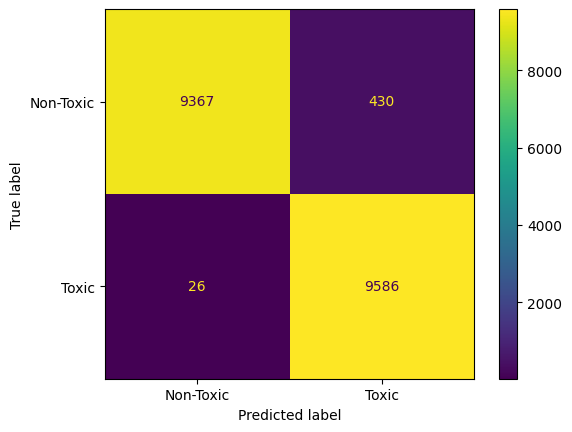

In [36]:
## Evaluate the model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

print(classification_report(y_test, predicted_labels))

cm = confusion_matrix(y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Toxic', 'Toxic'])
disp.plot(values_format = '')
plt.show()

The model has given an accuracy of 97% with the train as well as test data.

In [72]:
text = "Are we really expected to believe that in humanity's last stand,there was noone more qualified to command than a 10 year old kid? Almost all the northern lords are there (fuck you Glover),the Vale's men too,and a bunch of randoms from different kingdoms with military experience but they get bossed around by child."
text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
text = text.lower()
text = text.split()
text = np.array([vectorize_text(word, wv, 300) for word in text])
text = pad_sequences(text, maxlen=50, dtype='float32', padding='post', truncating='post')



In [73]:
text.shape

(58, 50, 300)

In [74]:
model.predict(text)[0][0] * 100

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


3.506092354655266

## Word2Vec model and FastText model

since the google model is not performing well on the data, it would be best to build the model from scratch exclusively for the reddit dataset.

In [109]:
from gensim.models import Word2Vec, FastText

df = pd.read_csv('data\kaggle_RC_2019-05.csv')

## Taking the sample of data
df_reduced = resample(df,
                      n_samples=50000,
                      stratify=df['controversiality'],
                      random_state=42)

df_reduced = df_reduced.reset_index().drop(columns = ['index'])
df_reduced.head()


feature = df_reduced['body']
target = df_reduced['controversiality']

oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X, y = oversampler.fit_resample(feature.values.reshape(-1,1), target)

df_balanced = pd.DataFrame({'body': X.flatten(), 'controversiality':y})


In [110]:
df_balanced.head()

,body,controversiality
0,Huh. Then my grandmother was the complete oppo...,0
1,The grinding is my main concern... Consumables...,0
2,I remember seeing the promo on TV via Star Wor...,0
3,Sounds good! I’ll join you in a bit then,0
4,Maybe I’m naive but I don’t understand how tha...,0


In [111]:
## preprocess and train test split the dataset

from bs4 import BeautifulSoup

def preprocess_text(sentence):
    sentence = str(sentence).lower()
    sentence = re.sub('[^a-zA-z0-9]',' ',sentence)
    sentence = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?','',sentence)
    sentence = BeautifulSoup(sentence,'lxml').get_text()

    return sentence

df_balanced['body'] = df_balanced['body'].apply(lambda x: preprocess_text(x))
X = df_balanced['body']
y = df_balanced['controversiality']

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df_balanced, test_size=0.2, random_state=33)


C:\Users\Vipina m\AppData\Local\Temp\ipykernel_26180\4052908335.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence,'lxml').get_text()


In [112]:
train_set

,body,controversiality
40902,i still listen to leo s podcast,0
920,good then maybe everyone can shut the hell up...,0
25243,damn right you are,0
84238,no foles is a good underdog story but did no...,1
74672,hopefully he s a dlc he has to be seeing as a...,1
...,...,...
27849,so wait how exactly would this work you d i...,0
92818,4 16 1999 ...,1
578,spartacus from downtown with a disjointed lab...,0
67975,gettleman needs to come to terms with the fact...,1


In [113]:

corpus_train = train_set['body']
corpus[:5]



['huh  then my grandmother was the complete opposite  my mother s family is the epitomy of protestant quaker moral repression  and my gma was the absolute picture perfect 50s kid  60s teen  married a preacher  stepford wife kind of thing   didn t work out too well for her  hence my mother s rebellion   my mom just told me   don t get pregnant in school  don t get married if you do  ',
 'the grinding is my main concern    consumables etc    i dont understand much  have been busy to keep myself updated',
 'i remember seeing the promo on tv via star world s tna friday airings  shit felt like a silly fever dream ',
 'sounds good  i ll join you in a bit then',
 'maybe i m naive but i don t understand how that would make them vote for the right  the party that is trying to cut funding to those very things ']

['huh  then my grandmother was the complete opposite  my mother s family is the epitomy of protestant quaker moral repression  and my gma was the absolute picture perfect 50s kid  60s teen  married a preacher  stepford wife kind of thing   didn t work out too well for her  hence my mother s rebellion   my mom just told me   don t get pregnant in school  don t get married if you do  ',
 'the grinding is my main concern    consumables etc    i dont understand much  have been busy to keep myself updated',
 'i remember seeing the promo on tv via star world s tna friday airings  shit felt like a silly fever dream ',
 'sounds good  i ll join you in a bit then',
 'maybe i m naive but i don t understand how that would make them vote for the right  the party that is trying to cut funding to those very things ']

In [116]:
## Train the word2vec model

word2vec_model = Word2Vec(sentences=corpus_train, vector_size=300, window=5, min_count=1)

def vectorize_with_word2vec(sentence, model, embedding_dim=100):
    """
    Vectorizes a sentence using Word2Vec model, handling OOV words by averaging the word vectors.
    
    :param sentence: The input sentence as a string
    :param model: The trained Word2Vec model
    :param embedding_dim: The dimensionality of the word vectors
    :return: Averaged word vector for the sentence
    """
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    
    if word_vectors:
        return np.array(word_vectors)  
    else:
        return np.zeros((1,embedding_dim))

In [129]:
X_train = train_set['body'].apply(lambda x: vectorize_with_word2vec(sentence=x, model=word2vec_model, embedding_dim=300))
X_train = pad_sequences(X_train, maxlen=50, padding="post", truncating="post", dtype="float32")
X_train = np.array(X_train)
y_train = train_set['controversiality']

X_test = test_set['body'].apply(lambda x: vectorize_with_word2vec(sentence=x, model=word2vec_model, embedding_dim=300))
X_test = pad_sequences(X_test, maxlen=50, padding="post", truncating="post", dtype="float32")
X_test = np.array(X_test)
y_test = test_set['controversiality']



In [128]:
len(X_train[0][0])

300

In [107]:
## define the dl model
model = Sequential()
model.add(GRU(64, return_sequences = False, input_shape = (50,300)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Vipina\FindJ\Resume\GitHub\Reddit_comments\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [130]:
##  Definig the early stopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

In [132]:
## train the model
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=early_stopping)

Epoch 1/100
971/971 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.6431 - loss: 0.5727 - val_accuracy: 0.6379 - val_loss: 0.5966
Epoch 2/100
971/971 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.6434 - loss: 0.5717 - val_accuracy: 0.6377 - val_loss: 0.5918
Epoch 3/100
971/971 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.6444 - loss: 0.5670 - val_accuracy: 0.6355 - val_loss: 0.5860
Epoch 4/100
971/971 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.6463 - loss: 0.5626 - val_accuracy: 0.6398 - val_loss: 0.5777
Epoch 5/100
971/971 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.6498 - loss: 0.5598 - val_accuracy: 0.6312 - val_loss: 0.5875
Epoch 6/100
971/971 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.6492 - loss: 0.5589 - val_accuracy: 0.6282 - val_loss: 0.5784
Epoch 7/100
971/971 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.6488 - loss: 0.5555 - val_accuracy: 0.6441 - val_loss: 0.5705
Epoch 8/100
971/971 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.6539 - loss: 0

607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
              precision    recall  f1-score   support

           0       0.62      0.77      0.69      9797
           1       0.69      0.52      0.59      9612

    accuracy                           0.65     19409
   macro avg       0.66      0.65      0.64     19409
weighted avg       0.66      0.65      0.64     19409



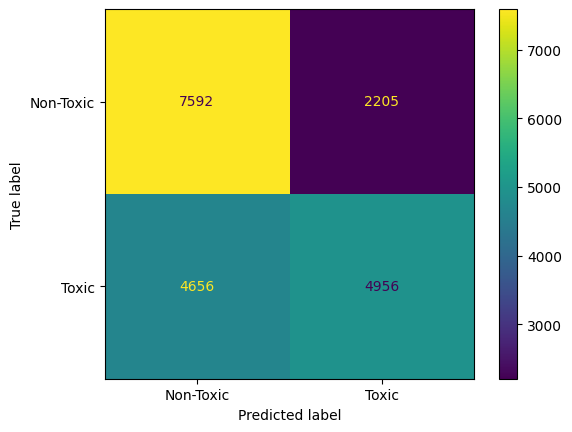

In [133]:
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

print(classification_report(y_test, predicted_labels))

cm = confusion_matrix(y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Toxic', 'Toxic'])
disp.plot(values_format = '')
plt.show()

In [144]:
text = "Are we really expected to believe that in humanity's last stand,there was noone more qualified to command than a 10 year old kid? Almost all the northern lords are there (fuck you Glover),the Vale's men too,and a bunch of randoms from different kingdoms with military experience but they get bossed around by child."
text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
text = text.lower()
text = text.split()
text = np.array([vectorize_with_word2vec(word, word2vec_model, 300) for word in text])
text = pad_sequences(text, maxlen=50, dtype='float32', padding='post', truncating='post')

In [145]:
model.predict(text)[0][0] * 100

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


48.90109300613403

The model is able to capture atleast 48% toxicity which is a significant value unlike how it classified the same text as non toxic with 3% toxicity which is a very low value

## FastText Model

In [138]:
corpus_train

40902                      i still listen to leo s podcast
920      good  then maybe everyone can shut the hell up...
25243                              damn right you are     
84238    no  foles is a good underdog story  but did no...
74672    hopefully he s a dlc  he has to be seeing as a...
                               ...                        
27849    so wait  how exactly would this work   you d i...
92818    4   16          1999                          ...
578      spartacus  from downtown with a disjointed lab...
67975    gettleman needs to come to terms with the fact...
23572        shet bud ur right  this rlly be a bruh moment
Name: body, Length: 77633, dtype: object

In [139]:
from gensim.models import FastText

fasttext_model = FastText(sentences=corpus_train, vector_size=300, window=5, min_count=1)

def vectorize_with_fasttext(sentence, model, embedding_dim=100):
    """
    Vectorizes a sentence using Word2Vec model, handling OOV words by averaging the word vectors.
    
    :param sentence: The input sentence as a string
    :param model: The trained Word2Vec model
    :param embedding_dim: The dimensionality of the word vectors
    :return: Averaged word vector for the sentence
    """
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    
    if word_vectors:
        return np.array(word_vectors)  
    else:
        return np.zeros((1,embedding_dim))

In [141]:
X_train = train_set['body'].apply(lambda x: vectorize_with_fasttext(sentence=x, model=fasttext_model, embedding_dim=300))
X_train = pad_sequences(X_train, maxlen=50, padding="post", truncating="post", dtype="float32")
X_train = np.array(X_train)
y_train = train_set['controversiality']

X_test = test_set['body'].apply(lambda x: vectorize_with_fasttext(sentence=x, model=fasttext_model, embedding_dim=300))
X_test = pad_sequences(X_test, maxlen=50, padding="post", truncating="post", dtype="float32")
X_test = np.array(X_test)
y_test = test_set['controversiality']

In [147]:
## Using the same model for learning but with a different train and test sets to check the change in performance

model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=64, callbacks=early_stopping)

Epoch 1/100
971/971 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.5467 - loss: 0.6779 - val_accuracy: 0.5720 - val_loss: 0.6643
Epoch 2/100
971/971 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.5576 - loss: 0.6694 - val_accuracy: 0.5641 - val_loss: 0.6611
Epoch 3/100
971/971 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.5730 - loss: 0.6594 - val_accuracy: 0.5914 - val_loss: 0.6545
Epoch 4/100
971/971 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.5803 - loss: 0.6536 - val_accuracy: 0.6034 - val_loss: 0.6375
Epoch 5/100
971/971 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.5981 - loss: 0.6361 - val_accuracy: 0.6201 - val_loss: 0.6264
Epoch 6/100
971/971 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.6091 - loss: 0.6229 - val_accuracy: 0.6137 - val_loss: 0.6219
Epoch 7/100
971/971 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.6257 - loss: 0.6077 - val_accuracy: 0.6256 - val_loss: 0.6039
Epoch 8/100
971/971 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.6396 - loss: 0

This model is giving a greater accuracy as compared to the model that was trained with word2vec model

607/607 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
              precision    recall  f1-score   support

           0       0.68      0.85      0.76      9797
           1       0.80      0.60      0.68      9612

    accuracy                           0.73     19409
   macro avg       0.74      0.72      0.72     19409
weighted avg       0.74      0.73      0.72     19409



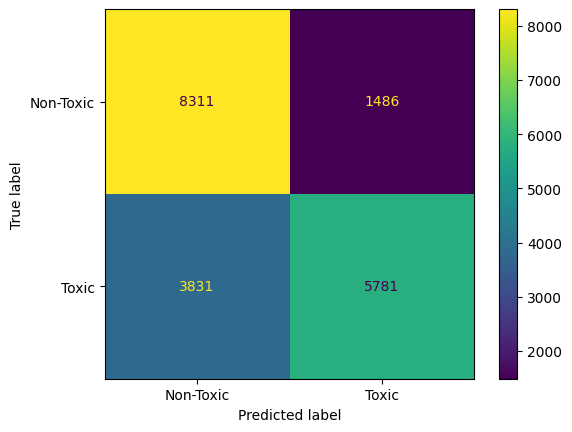

In [148]:
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

print(classification_report(y_test, predicted_labels))

cm = confusion_matrix(y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Toxic', 'Toxic'])
disp.plot(values_format = '')
plt.show()

The model with fast-text is giving around 73% accuracy which is better than word2vec

In [149]:
text = "Are we really expected to believe that in humanity's last stand,there was noone more qualified to command than a 10 year old kid? Almost all the northern lords are there (fuck you Glover),the Vale's men too,and a bunch of randoms from different kingdoms with military experience but they get bossed around by child."
text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
text = text.lower()
text = text.split()
text = np.array([vectorize_with_fasttext(word, fasttext_model, 300) for word in text])
text = pad_sequences(text, maxlen=50, dtype='float32', padding='post', truncating='post')

In [150]:
model.predict(text)[0][0] * 100

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


49.163344502449036

In [156]:
cor = train_set['body'].to_list() + test_set['body'].to_list()
corpus

['i still listen to leo s podcast',
 'good  then maybe everyone can shut the hell up and we can move on ',
 'damn right you are     ',
 'no  foles is a good underdog story  but did not have a better game  stat wise  flacco was more accurate  but threw the ball less  flacco had 8 7 yards per attempt  whereas foles had slightly less  8 67   given flacco s run throughout the entire playoffs  tossing 12 tds and 0 ints  he is the better player in my opinion  he s got the best postseason since montana ',
 'hopefully he s a dlc  he has to be seeing as a recent datamine revealed that 19 dlc characters are being released ',
 'he s a lot more like the democrats than he will admit  if he doesn t keep harping on the same shit  he doesn t have much else to contribute to the discussion ',
 'similar in other regions ',
 'that is a gas station',
 'well one is a rb  the other a wr  so that s a start ',
 'no particular order  mahomes  donald  mack  hopkins  cox  thomas  brees   wagner  gurley  and e  ja

97042